In [1]:
import os, sys
sys.path.append('/Users/premyslciompa/Documents/Projekty/SciApp/python')

from funkce import *
from zobrazovaci_funkce import *
import pandas
import pymongo

client = pymongo.MongoClient()
db = client.MyDb
dataCollection = db.Data

import bson
import pickle
import time
import math

from concurrent.futures import ThreadPoolExecutor
pool = ThreadPoolExecutor()

import matplotlib

%matplotlib inline

import scipy.stats

/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: ComplexWarning: Casting complex values to real discards the imaginary part


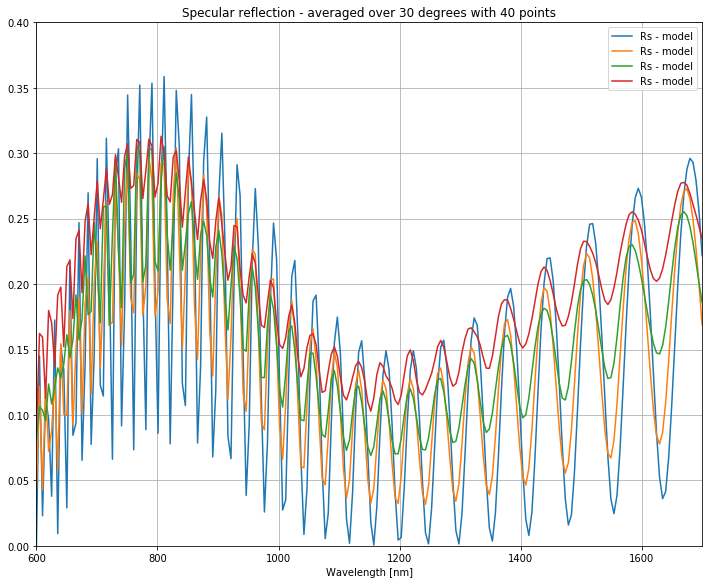

CPU times: user 57.4 s, sys: 379 ms, total: 57.8 s
Wall time: 58.2 s


In [23]:
%%time

def general_func_angle(wvs, options_input, angle):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 0,
            'n_select': 0,
            'wavelength': wvs[index],
            'angle': angle,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        
        width_grating = 530
        width_ref_vrstva = 20
       
        perm_substrate = 1.5**2
        perm_ref_vrstva = 2**2
        
        structure = {
            'bound_selectors': [
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1500,
            'data': [
                {'width': 300, 'periodic': False, 'coherent': True,
                 'permittivity': [ perm_ref_vrstva, 0, 0, 0,  perm_ref_vrstva, 0, 0, 0,  perm_ref_vrstva]},
               {'width': 10000, 'periodic': False, 'coherent': True,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]}, 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]


def angle_avg(angle_diff, angle_avg_points):
    list_angle_avg = []
    weighted_points = np.linspace(-3*angle_diff,3*angle_diff, angle_avg_points)
    weights = scipy.stats.norm.pdf(weighted_points,0,angle_diff)/scipy.stats.norm.pdf(weighted_points,0,angle_diff).sum()
    
    for x in range(angle_avg_points):
        list_angle_avg.append(weights[x]*general_func_angle(wv_array, options_input, weighted_points[x]))
    
    rs_0 = np.empty((angle_avg_points,len(wv_array)))
    rp_0 = np.empty((angle_avg_points,len(wv_array)))

    for x in range(angle_avg_points):
        rs_0[x] = list_angle_avg[x][:,0,0]
        rp_0[x] = list_angle_avg[x][:,1,0]
        
    fig3 = plt.figure(15, figsize=(10, 10/6.75*5.55))
    plt.title("Specular reflection - averaged over " + str(angle_diff) + ' degrees with ' + str(angle_avg_points) + ' points')
    plt.plot(wv_array, rs_0.sum(axis=0),label='Rs - model')
    #plt.plot(wv_array, rp_0.sum(axis=0), 'b--', label='Rp - model')
    plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 0.4])
    plt.xlabel(options_input['dependence']['label'])
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    return rs_0.mean(axis=0), rp_0.mean(axis=0) 

wv_array = np.linspace(600,1700,(1700-600)/5)
options_input = {
    'divisions': wv_array.size,
    'divisions_start': wv_array[0], 
    'divisions_end': wv_array[-1],
    'dependence': {
        'name': 'wavelength',  ##angle // wavelength // structure
        'label': 'Wavelength [nm]'
    }
}

values_angle_avg_02 = angle_avg(0.0001,1)
values_angle_avg_02 = angle_avg(10,10)
values_angle_avg_02 = angle_avg(20,20)
values_angle_avg_02 = angle_avg(30,40)
plt.show()

/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:83: ComplexWarning: Casting complex values to real discards the imaginary part


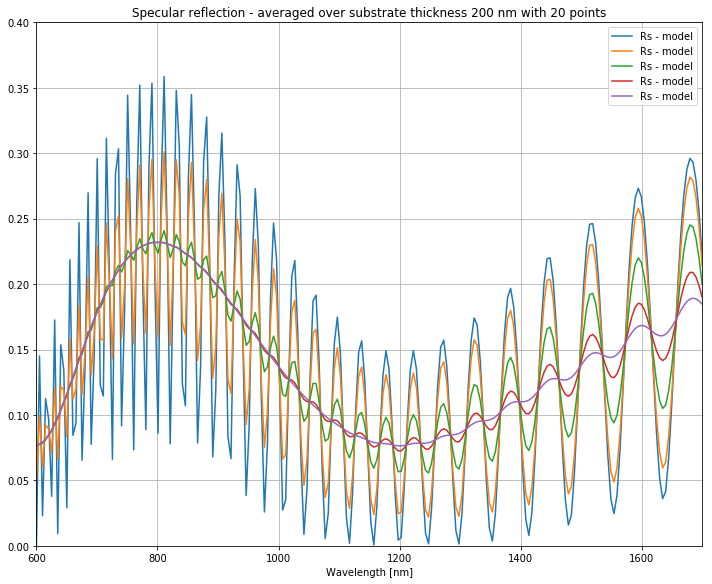

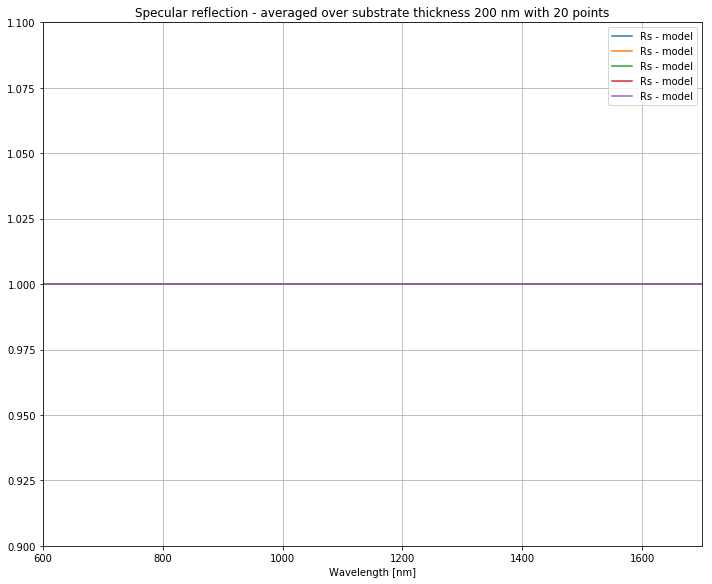

CPU times: user 42.1 s, sys: 341 ms, total: 42.5 s
Wall time: 43 s


In [65]:
%%time

def general_func_thickness(wvs, options_input, thickness):
    
    def get_structure_and_options(index):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 0,
            'n_select': 0,
            'wavelength': wvs[index],
            'angle': 0,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        
        width_grating = 530
        width_ref_vrstva = 20
       
        perm_substrate = 1.5**2
        perm_ref_vrstva = 2**2
        
        structure = {
            'bound_selectors': [
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1500,
            'data': [
                {'width': 300, 'periodic': False, 'coherent': True,
                 'permittivity': [ perm_ref_vrstva, 0, 0, 0,  perm_ref_vrstva, 0, 0, 0,  perm_ref_vrstva]},
                {'width': thickness, 'periodic': False, 'coherent': True,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]}, 
             ]}
        
        return options, structure

    def calculate_from_structure_and_options(index):
        options, structure = get_structure_and_options(index)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    indexes = range(wvs.size)
    results = list(map(calculate_from_structure_and_options,indexes))
    

    return get_coeffs(np.array(results))[0]

def thickness_avg(thickness_diff, thickness_avg_points):
    list_thickness_avg = []
    weighted_points = np.linspace(-3*thickness_diff + 10000,3*thickness_diff + 10000, thickness_avg_points)
    weights = scipy.stats.norm.pdf(weighted_points,10000,thickness_diff)/scipy.stats.norm.pdf(weighted_points,10000,thickness_diff).sum()
    for x in range(thickness_avg_points):
        list_thickness_avg.append(weights[x]*general_func_thickness(wv_array, options_input, weighted_points[x]))
    
    rs_0 = np.empty((thickness_avg_points,len(wv_array)))
    rp_0 = np.empty((thickness_avg_points,len(wv_array)))
    ts_0 = np.empty((thickness_avg_points,len(wv_array)))
    tp_0 = np.empty((thickness_avg_points,len(wv_array)))

    for x in range(thickness_avg_points):
        rs_0[x] = list_thickness_avg[x][:,0,0]
        rp_0[x] = list_thickness_avg[x][:,1,0]
        ts_0[x] = list_thickness_avg[x][:,2,0]
        tp_0[x] = list_thickness_avg[x][:,3,0]
        
    
    plt.figure(15, figsize=(10, 10/6.75*5.55))
    plt.title("Specular reflection - averaged over substrate thickness " + str(thickness_diff) + ' nm with ' + str(thickness_avg_points) + ' points')
    plt.plot(wv_array, rs_0.sum(axis=0), label='Rs - model')
    #plt.plot(wv_array, rp_0.mean(axis=0) , 'b--', label='Rp - model')
    plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 0.4])
    plt.xlabel(options_input['dependence']['label'])
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    
    plt.figure(16, figsize=(10, 10/6.75*5.55))
    plt.title("Specular reflection - averaged over substrate thickness " + str(thickness_diff) + ' nm with ' + str(thickness_avg_points) + ' points')
    plt.plot(wv_array, (rs_0.sum(axis=0) + rp_0.sum(axis=0) + ts_0.sum(axis=0) + tp_0.sum(axis=0))/2, label='Rs - model')
    #plt.plot(wv_array, rp_0.mean(axis=0) , 'b--', label='Rp - model')
    plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0.9, 1.1])
    plt.xlabel(options_input['dependence']['label'])
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    #plt.show()
    
    return rs_0.sum(axis=0), rp_0.sum(axis=0) 

values_thickness_avg_50 = thickness_avg(0.00001, 1)
values_thickness_avg_50 = thickness_avg(50, 5)
values_thickness_avg_50 = thickness_avg(100, 10)
values_thickness_avg_50 = thickness_avg(150, 15)
values_thickness_avg_50 = thickness_avg(200, 20)
plt.show()

/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: ComplexWarning: Casting complex values to real discards the imaginary part


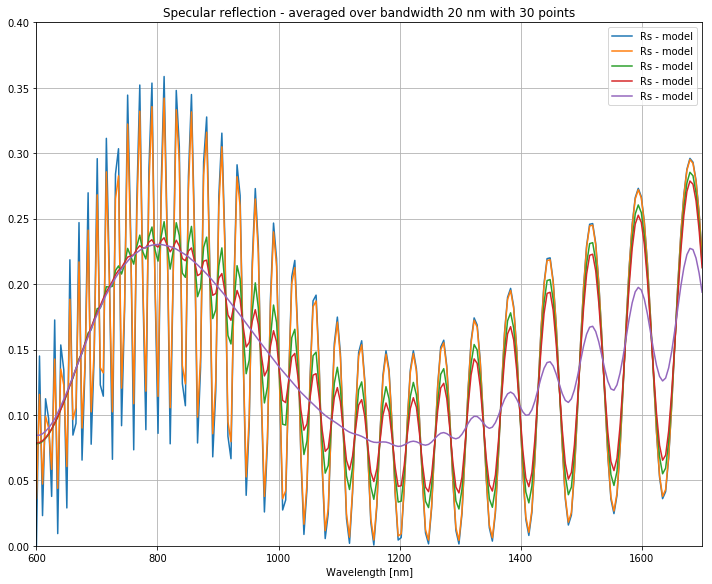

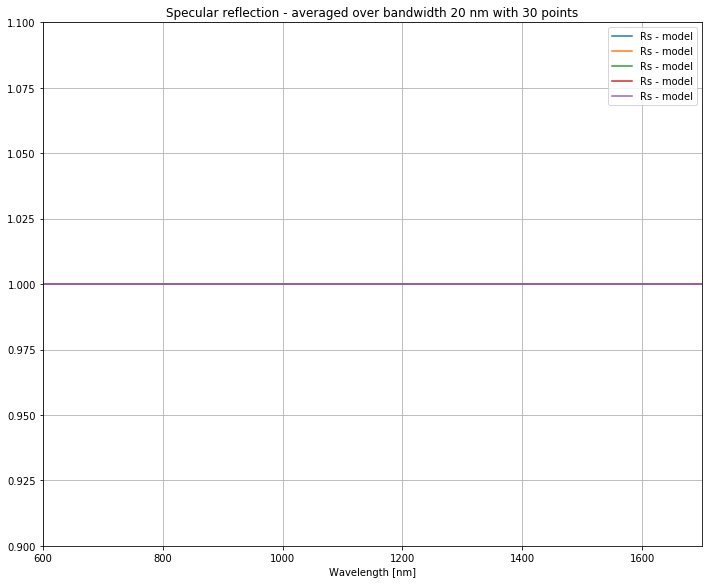

CPU times: user 59.5 s, sys: 472 ms, total: 60 s
Wall time: 1min


In [62]:
%%time

def general_func_bandwidth(wvs, options_input, bandwidth, avg_points):
    
    def get_structure_and_options(wv):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 0,
            'n_select': 0,
            'wavelength': wv,
            'angle': 0,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        
        width_grating = 530
        width_ref_vrstva = 20
       
        perm_substrate = 1.5**2
        perm_ref_vrstva = 2**2
        
        structure = {
            'bound_selectors': [
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1500,
            'data': [
                 {'width': 300, 'periodic': False, 'coherent': True,
                 'permittivity': [ perm_ref_vrstva, 0, 0, 0,  perm_ref_vrstva, 0, 0, 0,  perm_ref_vrstva]},
                {'width': 10000, 'periodic': False, 'coherent': True,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]}, 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(wv):
        options, structure = get_structure_and_options(wv)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    def bandwidth_avg(wv):
        list_avg = []
        weighted_points = np.linspace(-3*bandwidth + wv,3*bandwidth + wv, avg_points)
        weights = scipy.stats.norm.pdf(weighted_points, wv,bandwidth)/scipy.stats.norm.pdf(weighted_points,wv,bandwidth).sum()
    
        for x in range(avg_points):
            result = calculate_from_structure_and_options(weighted_points[x])
            list_avg.append(weights[x]*np.array([result['coefficients'][0,0],result['coefficients'][1,0],result['coefficients'][2,0],result['coefficients'][3,0]]))
 
        rs_0 = np.empty(avg_points)
        rp_0 = np.empty(avg_points) 
        ts_0 = np.empty(avg_points) 
        tp_0 = np.empty(avg_points) 

        for x in range(avg_points):
            rs_0[x] = list_avg[x][0]
            rp_0[x] = list_avg[x][1]
            ts_0[x] = list_avg[x][2]
            tp_0[x] = list_avg[x][3]
        return rs_0.sum(axis=0), rp_0.sum(axis=0), ts_0.sum(axis=0), tp_0.sum(axis=0)
    
    return list(map(bandwidth_avg,wv_array))

def calc_bandwidth(bandwidth, avg_points):
    values_bandwidth_avg = np.array(general_func_bandwidth(wv_array,options_input, bandwidth, avg_points))
    
    plt.figure(15, figsize=(10, 10/6.75*5.55))
    plt.title("Specular reflection - averaged over bandwidth " + str(bandwidth) + ' nm with ' + str(avg_points) + ' points' )
    plt.plot(wv_array, values_bandwidth_avg[:,0], label='Rs - model')
    #plt.plot(wv_array, values_bandwidth_avg[:,1], 'b--', label='Rp - model')
    plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 0.4])
    plt.xlabel(options_input['dependence']['label'])
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    plt.figure(16, figsize=(10, 10/6.75*5.55))
    plt.title("Specular reflection - averaged over bandwidth " + str(bandwidth) + ' nm with ' + str(avg_points) + ' points' )
    plt.plot(wv_array, (values_bandwidth_avg[:,0] + values_bandwidth_avg[:,1] + values_bandwidth_avg[:,2] + values_bandwidth_avg[:,3])/2, label='Rs - model')
    plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0.9, 1.1])
    plt.xlabel(options_input['dependence']['label'])
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    return values_bandwidth_avg
    
values_bandwidth_1 = calc_bandwidth(0.001,1)
values_bandwidth_1 = calc_bandwidth(2,5)
values_bandwidth_1 = calc_bandwidth(7,15)
values_bandwidth_1 = calc_bandwidth(9,20)
values_bandwidth_1 = calc_bandwidth(20,30)
plt.show()

/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:108: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/premyslciompa/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part


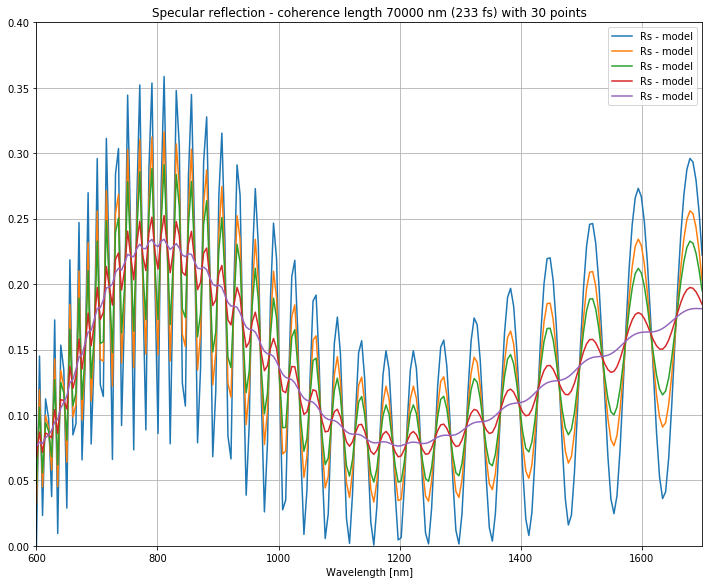

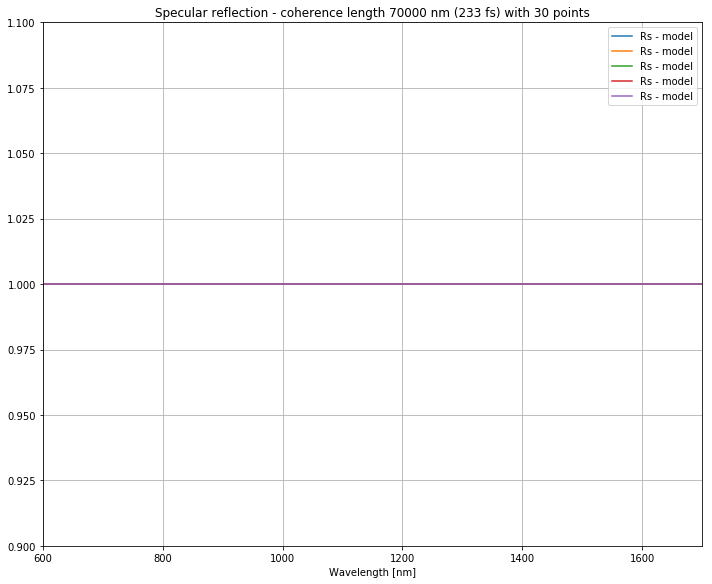

CPU times: user 1min 2s, sys: 467 ms, total: 1min 3s
Wall time: 1min 3s


In [67]:
%%time

def general_func_coherence_length(wvs, options_input, coherence_length, avg_points):
    
    def get_structure_and_options(wv):
        
        options = {
            'bound_selectors': [
                ['wavelength'],  # Select the proper attribute to be dependant
            ],
            'n_terms': 0,
            'n_select': 0,
            'wavelength': wv,
            'angle': 0,
            'divisions': options_input['divisions'],
            'divisions_start': options_input['divisions_start'],
            'divisions_end': options_input['divisions_end'],
            'dependence': options_input['dependence']
        }

        fill_grating = 0.5
        
        width_grating = 530
        width_ref_vrstva = 20
       
        perm_substrate = 1.5**2
        perm_ref_vrstva = 2**2
        
        structure = {
            'bound_selectors': [
            ],
            'superstrate': 1,  # indexes, not perm
            'substrate': 1,
            'period': 1500,
            'data': [
                {'width': 300, 'periodic': False, 'coherent': True,
                 'permittivity': [ perm_ref_vrstva, 0, 0, 0,  perm_ref_vrstva, 0, 0, 0,  perm_ref_vrstva]},
                {'width': 10000, 'periodic': False, 'coherent': True,
                 'permittivity': [ perm_substrate, 0, 0, 0,  perm_substrate, 0, 0, 0,  perm_substrate]}, 
            ]}
        
        return options, structure

    def calculate_from_structure_and_options(wv):
        options, structure = get_structure_and_options(wv)
        coherent_subsystems = get_coherent_subsets(structure)
        
        for item in coherent_subsystems:
            item['toeplitz_matrix'] = calculate_toeplitz_matrices(item, options)
            # Ke kazde podstrukture pridam jeji vypocitanou s-matici
            item['s_matrix'] = calculate_s_matrix(item, options, item['toeplitz_matrix'])

        # Pomoci partial waves algorithm vypocitam vysledne koherencni matice
        coh_matrices = calculate_incoherent_partial_waves(coherent_subsystems, options)

        reflectance_s, reflectance_p, transmittance_s, transmittance_p, diff_angles = get_observables(coh_matrices,
                                                                                                      options, structure)
        # Z vypocitanych matic ziskam potrebne veliciny a vratim je
        return {'coefficients': np.array([reflectance_s, reflectance_p, transmittance_s, transmittance_p]),
                        'diff_angles': diff_angles, 'structure': structure}
    
    def bandwidth_avg(wv):
        bandwidth = wv**2/coherence_length
        list_avg = []
        weighted_points = np.linspace(-3*bandwidth + wv,3*bandwidth + wv, avg_points)
        weights = scipy.stats.norm.pdf(weighted_points, wv,bandwidth)/scipy.stats.norm.pdf(weighted_points,wv,bandwidth).sum()
    
        for x in range(avg_points):
            result = calculate_from_structure_and_options(weighted_points[x])
            list_avg.append(weights[x]*np.array([result['coefficients'][0,0],result['coefficients'][1,0] ,result['coefficients'][2,0] ,result['coefficients'][3,0]]))
 
        rs_0 = np.empty(avg_points)
        rp_0 = np.empty(avg_points)
        ts_0 = np.empty(avg_points)
        tp_0 = np.empty(avg_points)

        for x in range(avg_points):
            rs_0[x] = list_avg[x][0]
            rp_0[x] = list_avg[x][1]
            ts_0[x] = list_avg[x][2]
            tp_0[x] = list_avg[x][3]
        return rs_0.sum(axis=0), rp_0.sum(axis=0), ts_0.sum(axis=0), tp_0.sum(axis=0)
    
    return list(map(bandwidth_avg,wv_array))

def calc_coherence_length(coherence_length, avg_points):
    values_bandwidth_avg = np.array(general_func_coherence_length(wv_array,options_input, coherence_length, avg_points))
    
    plt.figure(15, figsize=(10, 10/6.75*5.55))
    plt.title("Specular reflection - coherence length " + str(coherence_length) + ' nm (' + str(math.floor(coherence_length/300)) + ' fs) with ' + str(avg_points) + ' points' )
    plt.plot(wv_array, values_bandwidth_avg[:,0],label='Rs - model')
    #plt.plot(wv_array, values_bandwidth_avg[:,1], 'b--', label='Rp - model')
    plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0, 0.4])
    plt.xlabel(options_input['dependence']['label'])
    plt.legend(loc='upper right') 
    plt.grid(True)
    plt.tight_layout()
    
    plt.figure(16, figsize=(10, 10/6.75*5.55))
    plt.title("Specular reflection - coherence length " + str(coherence_length) + ' nm (' + str(math.floor(coherence_length/300)) + ' fs) with ' + str(avg_points) + ' points' )
    plt.plot(wv_array, (values_bandwidth_avg[:,0] + values_bandwidth_avg[:,1] + values_bandwidth_avg[:,2] + values_bandwidth_avg[:,3])/2,label='Rs - model')
    plt.axis([options_input['divisions_start'], options_input['divisions_end'], 0.9, 1.1])
    plt.xlabel(options_input['dependence']['label'])
    plt.legend(loc='upper right') 
    plt.grid(True)
    plt.tight_layout()
    return values_bandwidth_avg
    
wv_array = np.linspace(600,1700,(1700-600)/5)

values_coherence_1 = calc_coherence_length(200000000,1)
values_coherence_1 = calc_coherence_length(200000,10)
values_coherence_1 = calc_coherence_length(150000,15)
values_coherence_1 = calc_coherence_length(100000,20)
values_coherence_1 = calc_coherence_length(70000,30)
plt.show()